## Python + OpenCV

### Problem:

Detect circles with diameter greater than 10 pixels.

---

## Environment

Here I import a few packages and print a few versions to check everything is OK.

In [1]:
# Import platform (to check Python version only)
import platform

# Import Numpy
import numpy as np

# Import Matplotlib (to print its version only) and Pyplot
import matplotlib as mpl
from matplotlib import pyplot as plt
# Set the Matplotlib mode to inline
%matplotlib inline

# Import OpenCV
import cv2

# Import the IPython environment Markdown and display functions
from IPython.display import Markdown, display

# Define a way to print things with Markdown
def printmd(string):
    display(Markdown(string))

# Print versions
printmd("### Versions")
printmd("**Python version:** " + platform.python_version())
printmd("**OpenCV version:** " + cv2.__version__)
printmd("**Matplotlib version:** " + mpl.__version__)
printmd("**Numpy version:** " + np.__version__)

### Versions

**Python version:** 3.6.2

**OpenCV version:** 3.3.0

**Matplotlib version:** 2.0.2

**Numpy version:** 1.13.1

---

## Problem inputs

Where I set paths, constants and helper functions.

Then, images are loaded, converted to RGB and Grayscale and shown.

In [2]:
# Image file paths
FILES = ["./img/circles.png",
         "./img/shapes.jpg"]

# Circle minimum radius
RADIUS = 10


# Helper function to plot all image results every step
def plot_results(results, color=True):
    fig, axes = plt.subplots(len(FILES), 1 ,figsize=(10,10))
    
    for i in range(len(FILES)):
        if color:
            axes[i].imshow(results[i])
        else:
            axes[i].imshow(results[i], cmap='gray');
        axes[i].set_title(FILES[i])
        axes[i].axis("off")
    plt.show()

### RGB

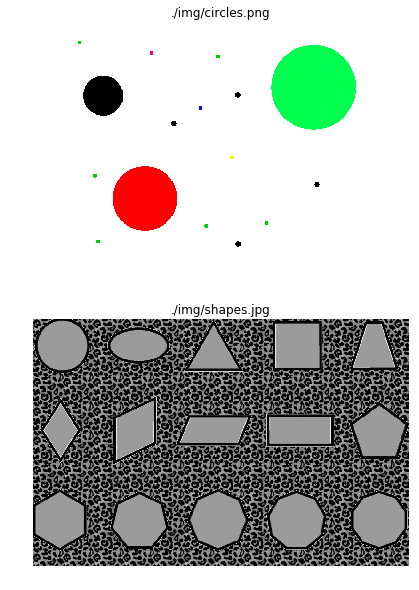

In [3]:
# Reading and converting to RGB
image={}
for i, file in enumerate(FILES):
    image[i] = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)

plot_results(image)

### Grayscale

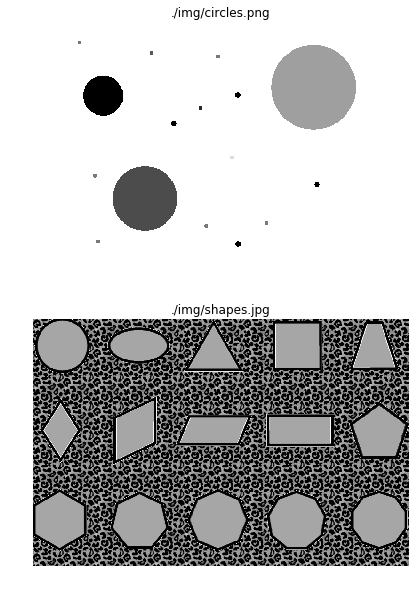

In [4]:
# Reading and converting to grayscale
gray_image={}
for i in range(len(FILES)):
    gray_image[i] = cv2.cvtColor(image[i], cv2.COLOR_RGB2GRAY);

plot_results(gray_image, color=False)

## Pre-processing

As images are pretty flat, Otsu's thresholding works alright to get BW images.

Then, I try to filter components smaller than the radius using mathematical morphology.

### Thresholding

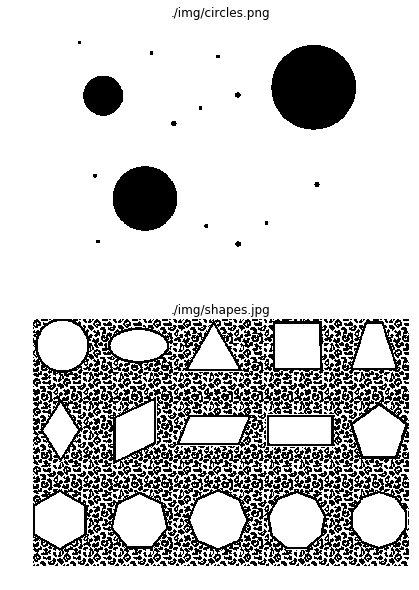

In [5]:
# Thresholding
bw_image={}
for i in range(len(FILES)):
    _, bw_image[i] = cv2.threshold(gray_image[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plot_results(bw_image, color=False)

Oops, the ROI of the first image is 0, but the ROI of the second image is 1. 

*(If nothing from here works, I should detect the background...)*

### Mophological filtering

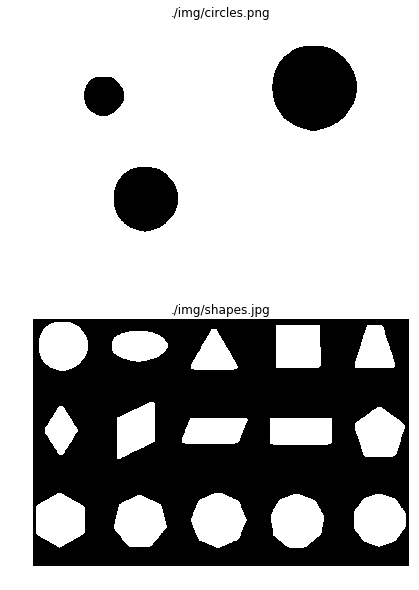

In [6]:
# Morphological filtering
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(RADIUS,RADIUS))

# It is not and ASF anymore
asf_image={}
for i in range(len(FILES)):
    asf_image[i] = bw_image[i].copy()
    asf_image[i] = cv2.morphologyEx(asf_image[i], cv2.MORPH_OPEN, kernel)
    asf_image[i] = cv2.morphologyEx(asf_image[i], cv2.MORPH_CLOSE, kernel)

plot_results(asf_image, color=False)

Eww... The ASF filtering was definetly a bad idea, but the morphological opening and closing operations are still useful for .

The small black components of the first image need to be closed. As they are far from each other, opening will have almost no effect.
The small black components of the second image also need to be opened. If I close them, everything will be a huge white blob.

Let's apply a morphological open first.

### Smoothing

Now I need nice shapes.

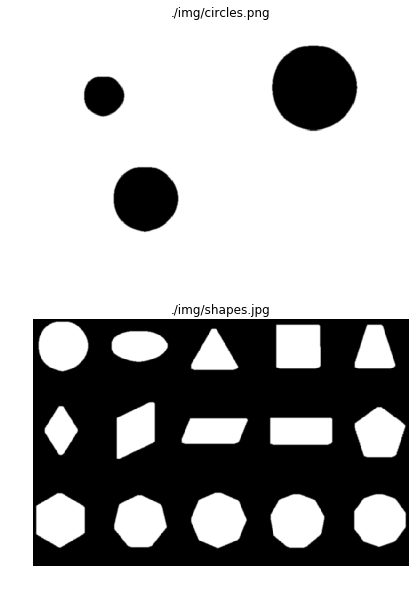

In [7]:
smooth_image={}
for i in range(len(FILES)):
    # It's just a Gaussian blur
    smooth_image[i] = cv2.GaussianBlur(asf_image[i], (5,5), 0)

plot_results(smooth_image, color=False)

## Processing

Finally I apply a Hough Circle Transform with the Canny and accumulator parameters fine tuned to the current problem and a minimun radius set to 10.

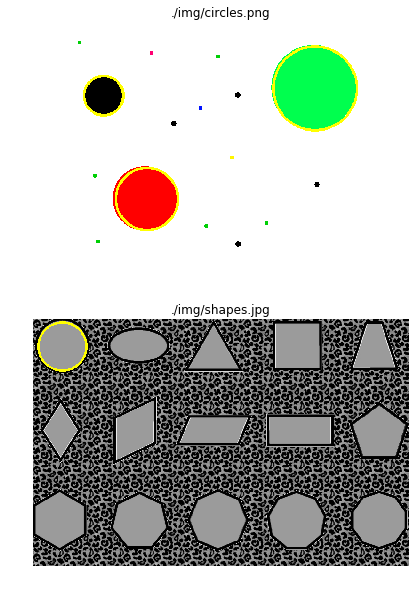

In [8]:
output = {}
circles = {}
for i in range(len(FILES)):
    # Apply the Hough Circle Transform
    circles[i] = cv2.HoughCircles(smooth_image[i], cv2.HOUGH_GRADIENT, 1, 10,
                                  param1 = 1,
                                  param2 = 35,
                                  minRadius = RADIUS,
                                  maxRadius = 0)

    # Plot circles over the original image
    output[i] = image[i].copy()
    if circles[i] is not None:
        clist = np.uint16(np.around(circles[i]))
        for c in clist[0,:]:
            cv2.circle(output[i], (c[0], c[1]), c[2], (255,255,0), 4)

plot_results(output)

Hmm... The circles are not well aligned.

## Post-processing

Where I align the circles.

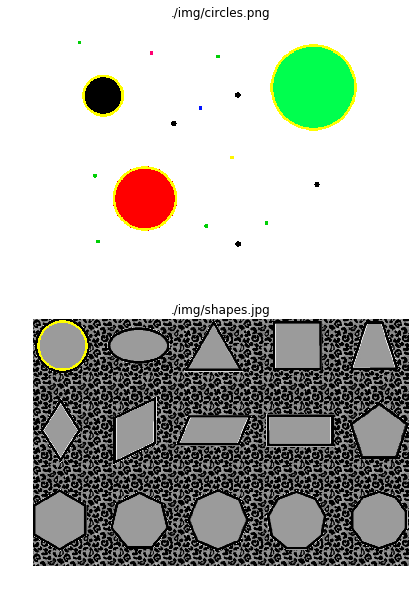

In [9]:
output = {}
for i in range(len(FILES)):
    # Copy the original image
    output[i] = image[i].copy()
    
    # If any circle is in a black component, invert the binary image
    if circles[i] is not None:
        clist = np.uint16(np.around(circles[i]))
        for c in clist[0,:]:
            if bw_image[i][c[1], c[0]] == 0:
                bw_image[i] = (255 - bw_image[i])
                break

    # Get the 8-connected components
    cc = cv2.connectedComponentsWithStats(bw_image[i], 8)
    
    # Plot circles over the orignal image using the HDT radius and the component centroid
    if circles[i] is not None:
        clist = np.uint16(np.around(circles[i]))
        for c in clist[0,:]:
            label = cc[1][c[1], c[0]]
            centroid = np.uint16(np.around(cc[3][label]))
            cv2.circle(output[i], (centroid[0], centroid[1]), c[2], (255,255,0), 4)

plot_results(output)